<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 26: Generative Adversarial Networks
### Notebook 2: 2D GAN

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
# 2D Gaussian GAN
# adapted from https://github.com/EmilienDupont/generative-adversarial-network
#                       /blob/master/generative_adversarial_network.py

In [2]:
from keras.layers import Dense, Input
from keras.layers.core import Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
data_dimensions = 2
noise_dimensions = 4
random_seed = 42

# Training parameters
batch_size = 32
number_of_examples = 10000
number_of_batches = int(number_of_examples / batch_size)

In [5]:
def make_generator(dense_list):
    generator_input = Input(shape=(noise_dimensions,))
    generator_dense_layers = []
    generator_activation_layers = []
    for i in range(len(dense_list)):
        if i==0:
            generator_dense_layers.append(Dense(dense_list[i])(generator_input))
        else:
            generator_dense_layers.append(Dense(dense_list[i])(generator_activation_layers[i-1]))
        generator_activation_layers.append(LeakyReLU(0.1)(generator_dense_layers[i]))

    generator_output = Dense(data_dimensions)(generator_activation_layers[len(dense_list)-1])

    generator = Model(inputs=generator_input, outputs=generator_output)
    # Generator loss does not matter, as generator will only be trained through GAN
    generator.compile(loss='mse', optimizer='adam')
    return generator

In [6]:
def make_discriminator(dense_list):
    discriminator_input = Input(shape=(data_dimensions,))
    discriminator_dense_layers = []
    discriminator_activation_layers = []
    for i in range(len(dense_list)):
        if i==0:
            discriminator_dense_layers.append(Dense(dense_list[i])(discriminator_input))
        else:
            discriminator_dense_layers.append(Dense(dense_list[i])(discriminator_activation_layers[i-1]))
        discriminator_activation_layers.append(LeakyReLU(0.1)(discriminator_dense_layers[i]))

    discriminator_output = Dense(1, activation='sigmoid')(discriminator_activation_layers[len(dense_list)-1])

    discriminator = Model(inputs=discriminator_input, outputs=discriminator_output)
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return (discriminator)

In [7]:
def make_gan(generator, discriminator):
    # The 'trainable" stuff is a bit subtle. To apply it to a model, we set it
    # for the model and then compile it. The result is that when we manipulate
    # that model (e.g., fitting it), the layers in the model will not update. But
    # if those layers are shared with other models, and their 'trainable' flag
    # was left to True, then they WILL update when we use those models. So the
    # 'trainable' flag for a model might better be named 'trainable_within_this_model'.
    # Here, we build the GAN so that when it runs, the generator learns, but the
    # discriminator does not. This is because the generator needs to use the output
    # of the discriminator, so we lock it down when the generator is learning. Then
    # we update the discriminator in its own step, using a 'trainable=True' model.
    discriminator.trainable = False 
    gan_input = Input(shape=(noise_dimensions,))
    gan_layer = generator(gan_input)
    gan_output = discriminator(gan_layer)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=2e-4))
    discriminator.trainable = True
    return(gan)

In [8]:
# The real data we're comparing to
def get_real_data():
    real_data = np.random.normal(5, 1, (number_of_examples, data_dimensions))
    return real_data

In [9]:
def get_batch_of_normal_noise(mean=0, std=1, shape=(batch_size, noise_dimensions)):
    return np.random.normal(mean, std, shape)

In [10]:
def train_discriminator(discriminator, batch_of_data, label):
    if label == 0:
        labels = np.zeros(batch_size).astype(int)
    else:
        labels = np.ones(batch_size).astype(int)
    discriminator_loss = discriminator.train_on_batch(batch_of_data, labels)
    return discriminator_loss

In [11]:
def train_generator(gan):
    noise_batch = get_batch_of_normal_noise()
    labels = np.ones(batch_size).astype(int)
    gan_loss = gan.train_on_batch(noise_batch, labels)
    return gan_loss

In [12]:
def pre_train_discriminator(discriminator, generator, real_data):
    shuffled_data = np.random.permutation(real_data)
    for batch in range(number_of_batches):
        # first train on a batch of real data
        batch_of_data = shuffled_data[batch * batch_size: (batch + 1) * batch_size]
        train_discriminator(discriminator, batch_of_data, 1)
        # now train on a batch of fake data
        noise_batch = get_batch_of_normal_noise()
        batch_of_data = generator.predict(noise_batch)
        train_discriminator(discriminator, batch_of_data, 0)

In [13]:
def train_gan_one_epoch(gan, generator, discriminator, real_data):
    shuffled_data = np.random.permutation(real_data)
    for batch in range(number_of_batches):
        # discriminator with real data
        batch_of_data = shuffled_data[batch * batch_size: (batch + 1) * batch_size]
        train_discriminator(discriminator, batch_of_data, 1)
        # generator
        gan_loss = train_generator(gan)
        # disriminator with fake data
        noise_batch = get_batch_of_normal_noise()
        batch_of_data = generator.predict(noise_batch)
        discriminator_loss = train_discriminator(discriminator, batch_of_data, 0)
        # generator
        gan_loss = train_generator(gan)
    return((gan_loss, discriminator_loss))

In [14]:
def plot_fake_and_real_data(fig, data, generator, num_points=256):
    ax = fig.gca()
    ax.axis('equal')

    noise_batch = get_batch_of_normal_noise(shape=(num_points, noise_dimensions))
    fake_data_batch = generator.predict(noise_batch)
    data_batch = data[np.random.randint(number_of_examples, size=num_points)]
    
    fake_mean_x = np.mean(fake_data_batch[:,0])
    fake_mean_y = np.mean(fake_data_batch[:,1])
    fake_std_x = np.std(fake_data_batch[:,0])
    fake_std_y = np.std(fake_data_batch[:,1])
    
    mean_x = np.mean(data_batch[:,0])
    mean_y = np.mean(data_batch[:,1])
    std_x = np.std(data_batch[:,0])
    std_y = np.std(data_batch[:,1])
    
    blue_color = '#2578c7'
    orange_color = '#fca429'

    c = patches.Ellipse((mean_x, mean_y), 2*std_x, 2*std_y, \
                        edgecolor=blue_color, fill=False, linewidth=5)
    ax.add_patch(c)
    c = patches.Ellipse((mean_x, mean_y), 2*std_x, 2*std_y, \
                        edgecolor='black', fill=False, linewidth=1)
    ax.add_patch(c)
    c = patches.Ellipse((fake_mean_x, fake_mean_y), 2*fake_std_x, 2*fake_std_y, \
                        edgecolor=orange_color, fill=False, linewidth=5)
    ax.add_patch(c)
    c = patches.Ellipse((fake_mean_x, fake_mean_y), 2*fake_std_x, 2*fake_std_y, \
                        edgecolor='black', fill=False, linewidth=1)
    ax.add_patch(c)
    
    ax.scatter(fake_data_batch[:,0],fake_data_batch[:,1], edgecolor='None', c=orange_color, alpha=0.3)
    ax.scatter(data_batch[:,0], data_batch[:,1], edgecolor='None', c=blue_color, alpha=0.3)

In [15]:
def get_models():
    generator = make_generator((16,))
    discriminator = make_discriminator((16,16))
    gan = make_gan(generator, discriminator)
    return (generator, discriminator, gan)

In [16]:
def train_gan():
    history = []
    rows = 3
    columns = 4
    number_of_epochs = 21
    plot_epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13]
    plot_number = 0
    
    np.random.seed(random_seed)
    real_data = get_real_data()
    (generator, discriminator, gan) = get_models()
    pre_train_discriminator(discriminator, generator, real_data)

    fig = plt.figure(figsize=(10, 8))
    for epoch in range(number_of_epochs):
        train_data = train_gan_one_epoch(gan, generator, discriminator, real_data)
        history.append(train_data)
        if epoch in plot_epochs:
            plt.subplot(rows, columns, plot_number+1)
            plot_fake_and_real_data(fig, real_data, generator)
            ax = fig.gca()
            ax.set_xlim(-1, 14)
            ax.set_ylim(-1, 16)
            plt.title('Epoch '+str(epoch))
            plot_number += 1
    plt.tight_layout()
    file_helper.save_figure('GAN-2D-learn-plots')
    plt.show()
    return np.array(history)

In [17]:
def draw_loss_plots(history):
    plt.clf()
    fig = plt.figure(figsize=(8,6))
    plt.plot(history[:,0], c='#008800', linewidth=2, label='generator loss')
    plt.plot(history[:,1], c='#aa00aa', linewidth=2, label='discriminator loss')
    ax = plt.gca()
    ax.legend(loc='upper right', shadow=True)
    file_helper.save_figure('GAN-2D-learn-history')
    plt.show()

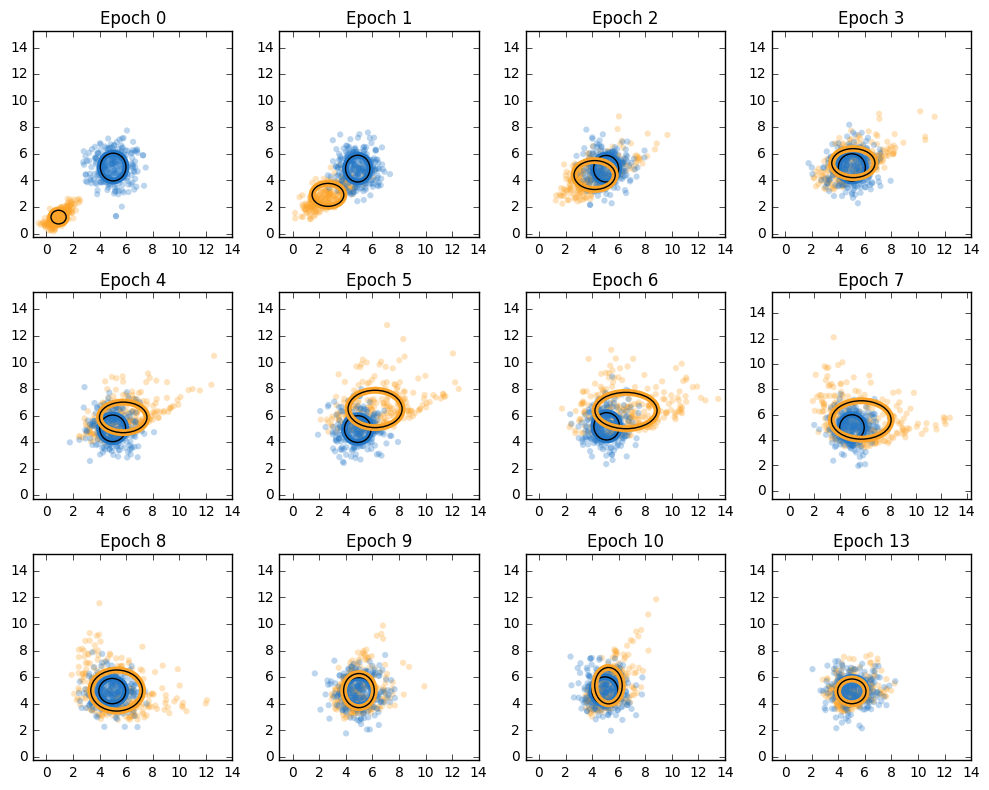

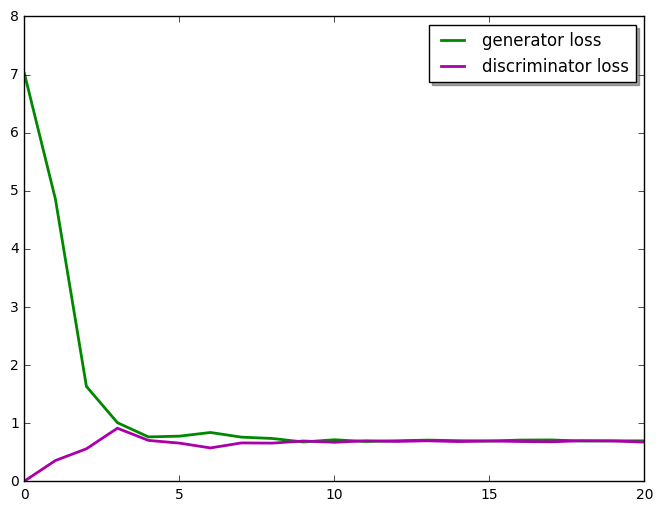

In [18]:
history = train_gan()
draw_loss_plots(history)